In [9]:
%pylab inline
%config InlineBackend.figure_format='retina'

from SuchTree import SuchTree, SuchLinkedTrees
import seaborn
import pandas
import dendropy
import numpy
from scipy.stats import pearsonr, kendalltau
from os import listdir
from itertools import combinations

from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

Populating the interactive namespace from numpy and matplotlib


In [2]:
%time

forest = {}
for t in listdir( 'data/ncldv' ) :
    forest[t] = SuchTree( 'data/ncldv/' + t )

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [3]:
import dendropy
from dendropy.simulate import treesim

# generate coalescent trees
for name,T in forest.items() :
    taxa = dendropy.TaxonNamespace( T.leafs )
    tree = treesim.pure_kingman_tree( taxon_namespace=taxa, pop_size=10000 )
    tree.write_to_path( 'data/simulated/kingman_' + name, schema='newick' )
    
for name,T in forest.items() :
    tree = treesim.birth_death_tree( 0.4, 0.1, num_extant_tips=T.n_leafs )
    tree.write_to_path( 'data/simulated/bd_' + name, schema='newick' )

for t in listdir( 'data/simulated/') :
    forest[t] = SuchTree( 'data/simulated/' + t )

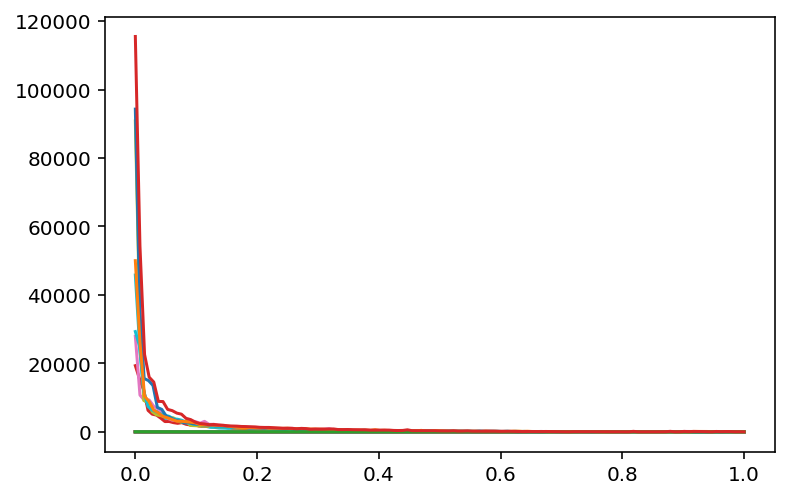

In [4]:
from scipy.linalg import eigvals
from scipy.stats import skew, entropy, gaussian_kde, kurtosis
import pyprind

spectra = {}
for a in forest.keys() :
    L = forest[a].laplacian()['laplacian']
    spectra[a] = L
    plot( linspace( 0, 1, len(L) ), eigvals( L ).real )

[]

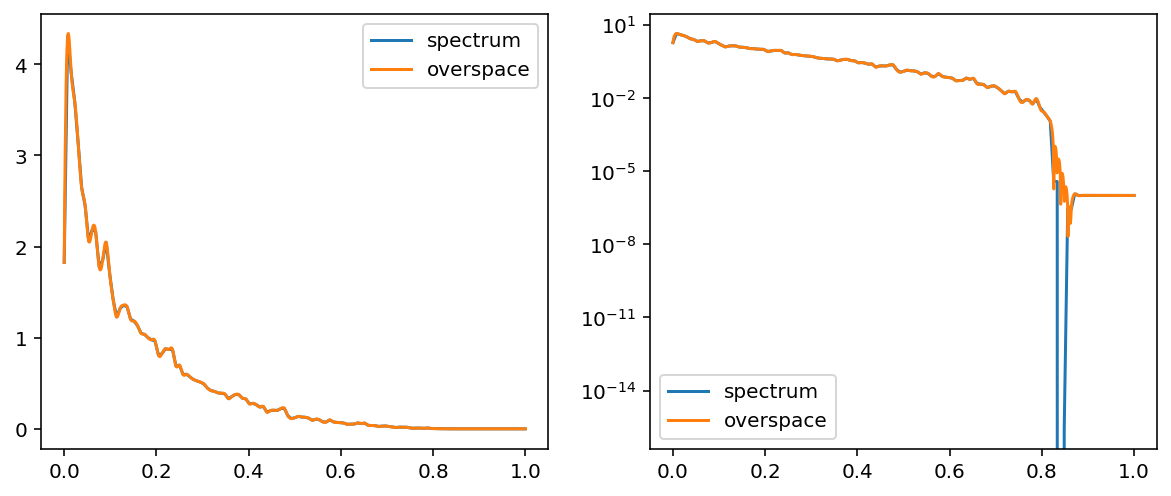

In [5]:
from scipy import interpolate

figure( figsize=( 10, 4 ) )

def overspace( spectrum, N=1000 ) :
    '''
    Project the spectrum into a higher or lower space of density N. 
    '''
    x = linspace( 0, 1, len( spectrum ) )
    s = interpolate.InterpolatedUnivariateSpline( x, spectrum )
    # numerical instability at small scalees is a problem, so let's keep things positive
    return sqrt( s( linspace( 0, 1, N ) )**2 )

L = list( forest.values() )[7].laplacian()['laplacian']

subplot( 1, 2, 1 )
N = 1000
plot( linspace( 0, 1, len(L) ), eigvals(L).real, label='spectrum' )
plot( linspace( 0, 1, N ), overspace( eigvals(L).real, N=N ), label='overspace' )
legend()

subplot( 1, 2, 2 )
N = 1000
plot( linspace( 0, 1, len(L) ), eigvals(L).real, label='spectrum' )
plot( linspace( 0, 1, N ), overspace( eigvals(L).real, N=N ), label='overspace' )
legend()
semilogy()

In [6]:
def pdd( a, b ) :
    '''Jensen-Shannon distance'''
    return ( 0.5 * entropy( a, b ) + 0.5 * entropy( b, a ) )**(0.5)

jsd = numpy.zeros( ( len(spectra), len(spectra) ) ) 

for i,a in enumerate( spectra.keys() ) :
    for j,b in enumerate( spectra.keys() ) :
        L1 = forest[a].laplacian()['laplacian']
        L2 = forest[b].laplacian()['laplacian']
        
        E1 = eigvals( L1 ).real
        E2 = eigvals( L2 ).real
        
        O1 = overspace( E1, 1000 )
        O2 = overspace( E2, 1000 )
    
        jsd[i,j] = pdd( O1, O2 )
        
names  = [ name.split('-final.')[0] for name in forest.keys() ]
jsdist = pandas.DataFrame( jsd, columns=names, index=names )

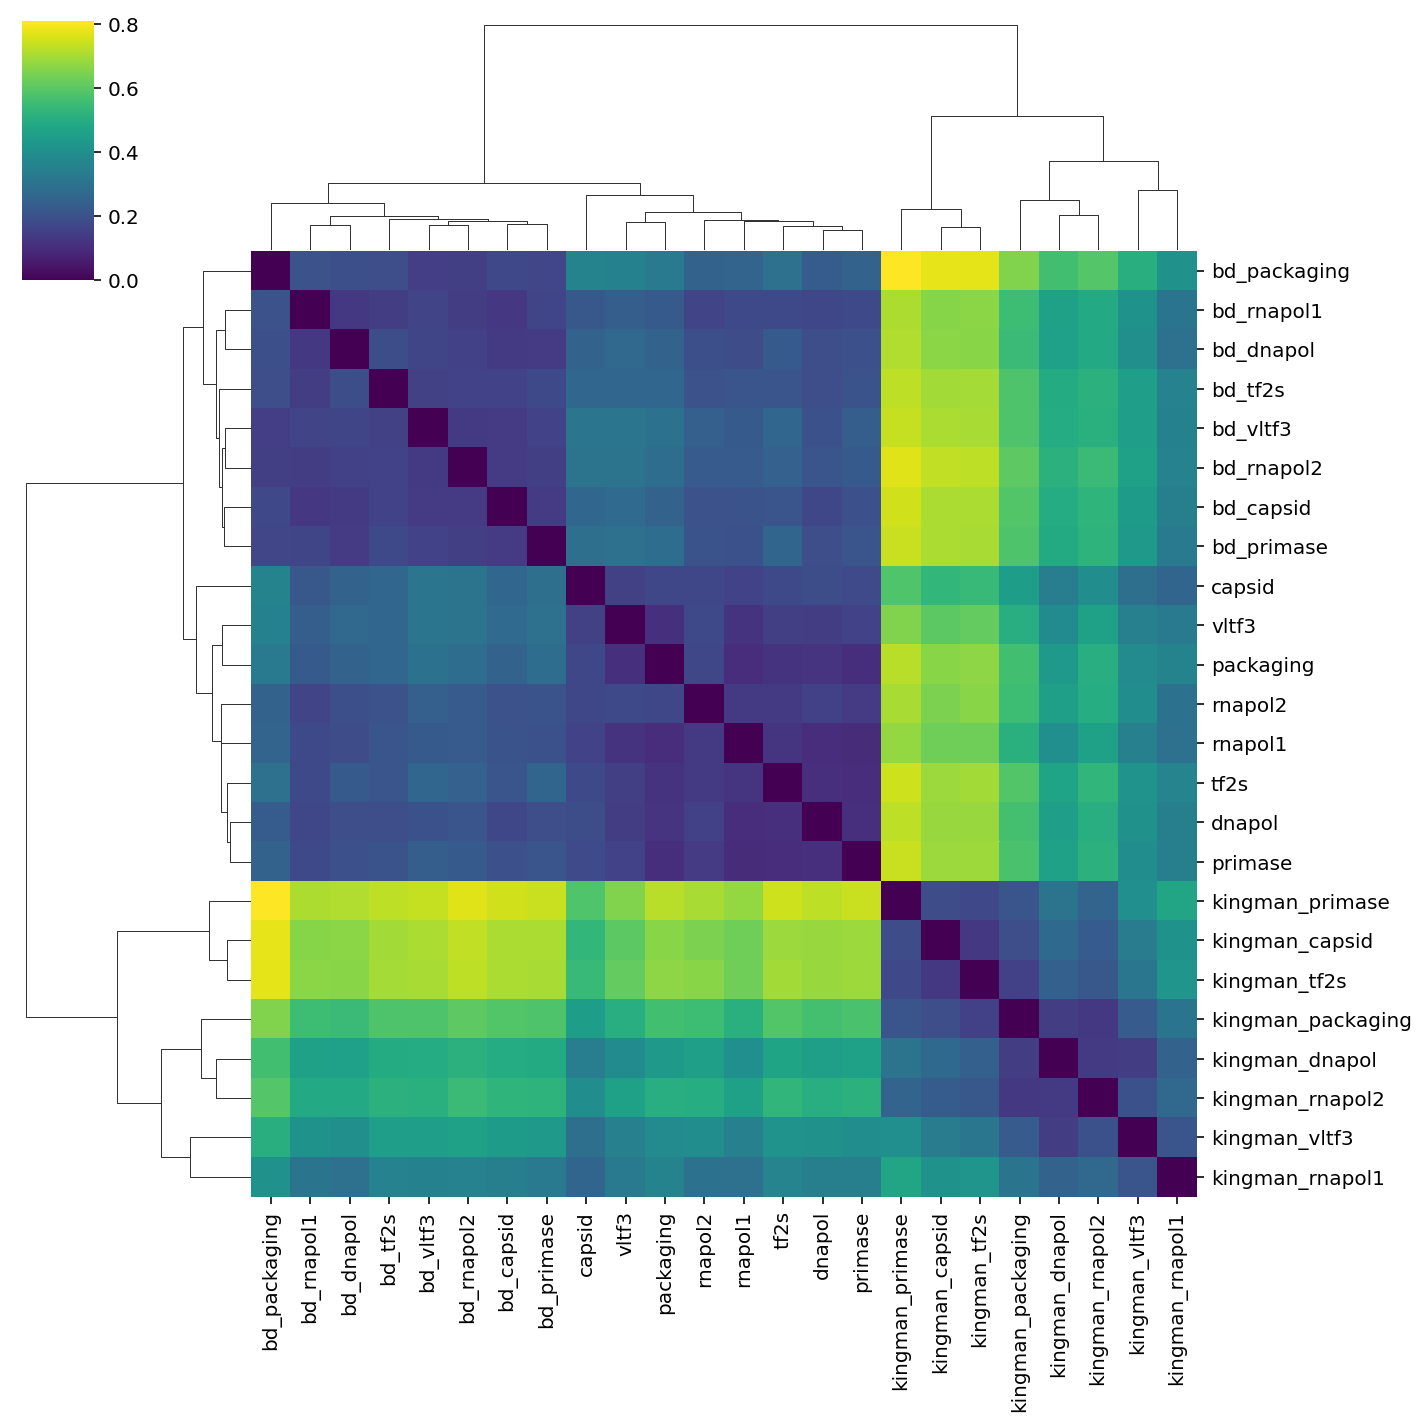

In [10]:
seaborn.clustermap( jsdist, cmap='viridis' )

In [11]:
jsdist

,dnapol,vltf3,primase,rnapol2,capsid,rnapol1,packaging,tf2s,bd_packaging,kingman_packaging,...,bd_rnapol2,bd_rnapol1,kingman_rnapol1,bd_primase,kingman_primase,kingman_dnapol,kingman_capsid,kingman_rnapol2,bd_dnapol,kingman_tf2s
dnapol,0.000000,0.144687,0.109859,0.151885,0.189734,0.101359,0.121295,0.108646,0.225400,0.570519,...,0.278555,0.244786,0.650479,0.205494,0.556278,0.346783,0.782643,0.295743,0.197951,0.703659
vltf3,0.144687,0.000000,0.158261,0.177856,0.155239,0.118080,0.113465,0.150145,0.332095,0.499262,...,0.410454,0.351467,0.572438,0.311857,0.481983,0.307753,0.710775,0.263235,0.307119,0.638893
primase,0.109859,0.158261,0.000000,0.139659,0.181204,0.100752,0.107248,0.104142,0.250981,0.556721,...,0.294951,0.260248,0.651945,0.229378,0.544933,0.343956,0.793200,0.297654,0.208403,0.712814
rnapol2,0.151885,0.177856,0.139659,0.000000,0.172058,0.136753,0.173896,0.134871,0.256272,0.554112,...,0.311947,0.264315,0.617367,0.230667,0.543083,0.333924,0.764027,0.273529,0.218448,0.678382
capsid,0.189734,0.155239,0.181204,0.172058,0.000000,0.160154,0.171870,0.178269,0.316797,0.441048,...,0.400612,0.348821,0.506281,0.310714,0.422956,0.238404,0.642678,0.225406,0.288221,0.567764
rnapol1,0.101359,0.118080,0.100752,0.136753,0.160154,0.000000,0.103380,0.125304,0.238828,0.511965,...,0.288121,0.260309,0.593759,0.240581,0.498692,0.297676,0.732617,0.238404,0.207269,0.652676
packaging,0.121295,0.113465,0.107248,0.173896,0.171870,0.103380,0.000000,0.117484,0.305569,0.536346,...,0.392808,0.319458,0.632538,0.285890,0.518076,0.341713,0.772890,0.298856,0.290192,0.700649
tf2s,0.108646,0.150145,0.104142,0.134871,0.178269,0.125304,0.117484,0.000000,0.275260,0.569913,...,0.372920,0.289173,0.655767,0.240008,0.553122,0.366118,0.799090,0.318359,0.267720,0.722943
bd_packaging,0.225400,0.332095,0.250981,0.256272,0.316797,0.238828,0.305569,0.275260,0.000000,0.619526,...,0.198122,0.140247,0.686372,0.162696,0.607214,0.381653,0.811064,0.343196,0.166807,0.723584
kingman_packaging,0.570519,0.499262,0.556721,0.554112,0.441048,0.511965,0.536346,0.569913,0.619526,0.000000,...,0.638743,0.665360,0.230396,0.666839,0.081589,0.282217,0.365979,0.342277,0.571332,0.323011


In [13]:
jsd

array([[0.        , 0.14468745, 0.10985873, 0.15188482, 0.18973392,
        0.10135884, 0.12129471, 0.10864586, 0.22959132, 0.51426633,
        0.2016781 , 0.22674701, 0.19395793, 0.6285069 , 0.21456739,
        0.19136234, 0.66647204, 0.22295154, 0.48519189, 0.46940338,
        0.66215848, 0.69257046, 0.21571131, 0.57925208],
       [0.14468745, 0.        , 0.15826069, 0.1778562 , 0.15523944,
        0.11807988, 0.11346501, 0.15014471, 0.35293355, 0.45126023,
        0.29940271, 0.33478743, 0.29878774, 0.55746334, 0.32964462,
        0.27208089, 0.59681562, 0.30530502, 0.43005249, 0.4138846 ,
        0.58812415, 0.61961449, 0.3183376 , 0.51752927],
       [0.10985873, 0.15826069, 0.        , 0.13965854, 0.18120359,
        0.10075215, 0.10724773, 0.10414181, 0.2516558 , 0.5198063 ,
        0.21049182, 0.2478213 , 0.21184046, 0.63116001, 0.22925143,
        0.20707734, 0.67162855, 0.23252907, 0.482037  , 0.46889672,
        0.66922265, 0.69935401, 0.23040461, 0.56039756],
       [0.151

In [15]:
from scipy.spatial.distance import squareform

squareform(jsd)

array([0.14468745, 0.10985873, 0.15188482, 0.18973392, 0.10135884,
       0.12129471, 0.10864586, 0.22959132, 0.51426633, 0.2016781 ,
       0.22674701, 0.19395793, 0.6285069 , 0.21456739, 0.19136234,
       0.66647204, 0.22295154, 0.48519189, 0.46940338, 0.66215848,
       0.69257046, 0.21571131, 0.57925208, 0.15826069, 0.1778562 ,
       0.15523944, 0.11807988, 0.11346501, 0.15014471, 0.35293355,
       0.45126023, 0.29940271, 0.33478743, 0.29878774, 0.55746334,
       0.32964462, 0.27208089, 0.59681562, 0.30530502, 0.43005249,
       0.4138846 , 0.58812415, 0.61961449, 0.3183376 , 0.51752927,
       0.13965854, 0.18120359, 0.10075215, 0.10724773, 0.10414181,
       0.2516558 , 0.5198063 , 0.21049182, 0.2478213 , 0.21184046,
       0.63116001, 0.22925143, 0.20707734, 0.67162855, 0.23252907,
       0.482037  , 0.46889672, 0.66922265, 0.69935401, 0.23040461,
       0.56039756, 0.17205845, 0.13675346, 0.17389613, 0.13487139,
       0.26157105, 0.51575402, 0.21152562, 0.24578296, 0.21562

In [166]:
from pathlib import Path

s = '(A:0.1,B:0.2,(C:0.3,D:0.4):0.5);'

In [171]:
s.count('(') == s.count(')') and s.count('(') >= 2

True